<a href="https://colab.research.google.com/github/saumya07p/Drowsy-Driver-Detection-using-Neural-Networks/blob/main/DrowsyDrivingDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Necessary Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Mounting Google Drive

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import random
import shutil
from PIL import Image
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

# Importing the dataset from Google Drive

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define paths to the dataset folders
train_folder = '/content/drive/MyDrive/DeepLearningProject/Drowsy_dataset/train'
test_folder = '/content/drive/MyDrive/DeepLearningProject/Drowsy_dataset/test'

train_folder1 = '/content/drive/MyDrive/DeepLearningProject/Drowsy_dataset/train1'
test_folder1 = '/content/drive/MyDrive/DeepLearningProject/Drowsy_dataset/test1'

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
# ])

In [ ]:
train_data = datasets.ImageFolder(root=train_folder, transform=transform)
test_data = datasets.ImageFolder(root=test_folder, transform=transform)

train_data1 = datasets.ImageFolder(root=train_folder1, transform=transform)
test_data1 = datasets.ImageFolder(root=test_folder1, transform=transform)

In [ ]:
train_loader = DataLoader(dataset=train_data1, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_data1, batch_size=32, shuffle=False)

In [ ]:
categories = ['NATURAL', 'DROWSY']

def dataset(original_folder_path, reduced_folder_path, num_images_per_category=200):

    os.makedirs(reduced_folder_path, exist_ok=True)
    for category in categories:
        category_path = os.path.join(original_folder_path, category)
        reduced_category_path = os.path.join(reduced_folder_path, category)
        os.makedirs(reduced_category_path, exist_ok=True)

        all_images = os.listdir(category_path)
        selected_images = random.sample(all_images, num_images_per_category)

        for img in selected_images:
            original_img_path = os.path.join(category_path, img)
            reduced_img_path = os.path.join(reduced_category_path, img)

            if original_img_path != reduced_img_path:
                shutil.copy(original_img_path, reduced_img_path)

dataset(train_folder, train_folder1, num_images_per_category=200)
dataset(test_folder, test_folder1, num_images_per_category=200)

In [ ]:
train_loader = DataLoader(train_data1, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data1, batch_size=32, shuffle=False)

In [ ]:
len(train_data.classes), len(test_data.classes)

(2, 2)

In [ ]:
len(train_data), len(test_data)

(5859, 1483)

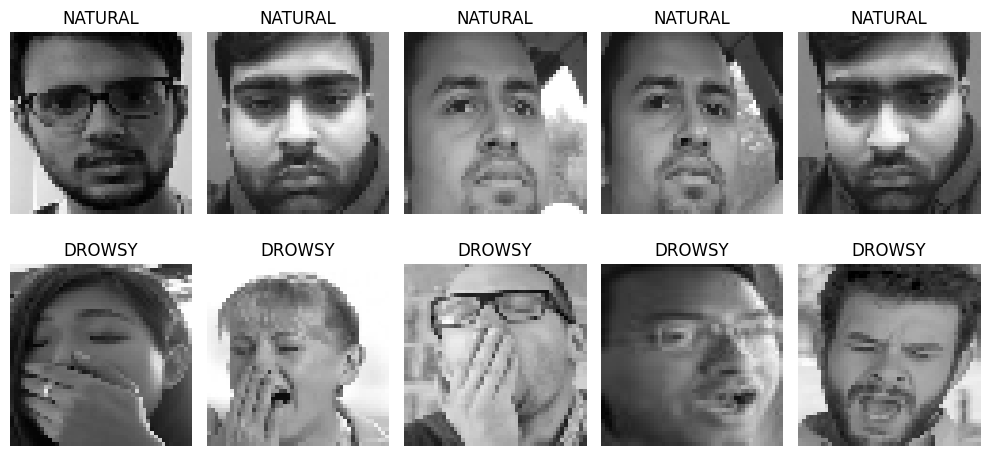

In [ ]:
test_data1 = '/content/drive/MyDrive/DeepLearningProject/Drowsy_dataset/test1'

categories = ['NATURAL', 'DROWSY']
plt.figure(figsize=(10, 5))

for i, category in enumerate(categories):
    folder_path = os.path.join(test_data1, category)
    images = os.listdir(folder_path)[:5]
    for j, img_name in enumerate(images):
        img_path = os.path.join(folder_path, img_name)
        img = Image.open(img_path).convert("RGB")
        plt.subplot(2, 5, i * 5 + j + 1)
        plt.imshow(img)
        plt.title(category)
        plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Convert image to tensor
img_tensor = transform(img)
# Print the tensor of the image
print(f'Tensor for image {img_name} from category {category}:')
print(img_tensor)

Tensor for image 50.png from category DROWSY:
tensor([[[0.6667, 0.6667, 0.6667,  ..., 0.5059, 0.5059, 0.5059],
         [0.6667, 0.6667, 0.6667,  ..., 0.5059, 0.5059, 0.5059],
         [0.6706, 0.6706, 0.6706,  ..., 0.5059, 0.5059, 0.5059],
         ...,
         [0.5804, 0.5804, 0.5804,  ..., 0.6471, 0.6471, 0.6471],
         [0.5804, 0.5804, 0.5804,  ..., 0.6431, 0.6431, 0.6431],
         [0.5804, 0.5804, 0.5804,  ..., 0.6431, 0.6431, 0.6431]],

        [[0.6667, 0.6667, 0.6667,  ..., 0.5059, 0.5059, 0.5059],
         [0.6667, 0.6667, 0.6667,  ..., 0.5059, 0.5059, 0.5059],
         [0.6706, 0.6706, 0.6706,  ..., 0.5059, 0.5059, 0.5059],
         ...,
         [0.5804, 0.5804, 0.5804,  ..., 0.6471, 0.6471, 0.6471],
         [0.5804, 0.5804, 0.5804,  ..., 0.6431, 0.6431, 0.6431],
         [0.5804, 0.5804, 0.5804,  ..., 0.6431, 0.6431, 0.6431]],

        [[0.6667, 0.6667, 0.6667,  ..., 0.5059, 0.5059, 0.5059],
         [0.6667, 0.6667, 0.6667,  ..., 0.5059, 0.5059, 0.5059],
         [0.

# Building the Model : CNN Architecture

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Convolutional Layer 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Adjust according to input image size
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, 1)  # Binary classification output

        # Sigmoid activation for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Apply convolutional layers and max pooling
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))

        # Flatten the tensor before feeding it to fully connected layers
        x = x.view(x.size(0), -1)

        # Apply fully connected layers
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)

        # Apply sigmoid to get probabilities
        x = self.sigmoid(x)

        return x

model = SimpleCNN().to(device)

Defining loss function and optimizer

In [ ]:
model = SimpleCNN()

criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

Checking for invalid images, or the corrupt image files

In [ ]:
# from PIL import Image
# import os

# def verify_images(folder_path):
#     invalid_images = []
#     for root, _, files in os.walk(folder_path):
#         for file in files:
#             file_path = os.path.join(root, file)
#             try:
#                 img = Image.open(file_path)  # Try opening the file as an image
#                 img.verify()  # Verify if it's a valid image
#             except (IOError, SyntaxError) as e:
#                 invalid_images.append(file_path)
#     return invalid_images

# # Check train and test folders
# train_invalid = verify_images('/content/drive/MyDrive/DeepLearningProject/Drowsy_dataset/train1')
# test_invalid = verify_images('/content/drive/MyDrive/DeepLearningProject/Drowsy_dataset/test1')

# print("Invalid Train Images:", train_invalid)
# print("Invalid Test Images:", test_invalid)

Removing the invalid image files

In [ ]:
# for file_path in train_invalid + test_invalid:
#     os.remove(file_path)
#     print(f"Removed invalid image: {file_path}")

In [ ]:
training_losses = []
training_accuracies = []

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    training_losses.append(epoch_loss)
    training_accuracies.append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

Epoch [1/10], Loss: 0.5959, Accuracy: 71.09%
Epoch [2/10], Loss: 0.3895, Accuracy: 83.10%
Epoch [3/10], Loss: 0.2953, Accuracy: 87.65%
Epoch [4/10], Loss: 0.2261, Accuracy: 90.84%
Epoch [5/10], Loss: 0.1458, Accuracy: 93.88%
Epoch [6/10], Loss: 0.0807, Accuracy: 96.96%
Epoch [7/10], Loss: 0.0366, Accuracy: 98.87%
Epoch [8/10], Loss: 0.0086, Accuracy: 99.80%
Epoch [9/10], Loss: 0.0028, Accuracy: 100.00%
Epoch [10/10], Loss: 0.0091, Accuracy: 99.76%


In [ ]:
model.eval()
val_loss = 0.0
val_correct = 0
val_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model(images)

        loss = criterion(outputs.squeeze(), labels)

        val_loss += loss.item()
        predicted = (outputs > 0.5).float()
        val_total += labels.size(0)
        val_correct += (predicted.squeeze() == labels).sum().item()

val_loss /= len(test_loader)
val_accuracy = 100 * val_correct / val_total
print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

Validation Loss: 0.7722, Accuracy: 89.91%


# Model Evaluation

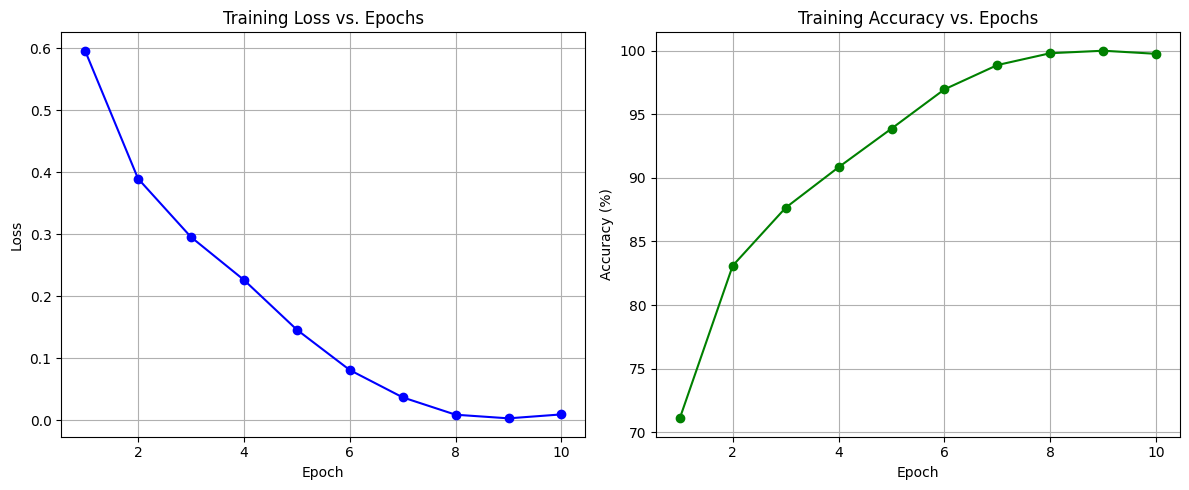

In [ ]:
# Plot the training loss and accuracy side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Loss graph
axes[0].plot(range(1, num_epochs + 1), training_losses, marker='o', color='blue')
axes[0].set_title("Training Loss vs. Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].grid(True)

# Accuracy graph
axes[1].plot(range(1, num_epochs + 1), training_accuracies, marker='o', color='green')
axes[1].set_title("Training Accuracy vs. Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy (%)")
axes[1].grid(True)

# Adjust layout and show
plt.tight_layout()
plt.show()

In [ ]:
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model(images)
        preds = (outputs > 0.5).float()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

print("Classification Report:\n", classification_report(all_labels, all_preds))

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.80      0.89       642
         1.0       0.83      1.00      0.91       617

    accuracy                           0.90      1259
   macro avg       0.91      0.90      0.90      1259
weighted avg       0.92      0.90      0.90      1259



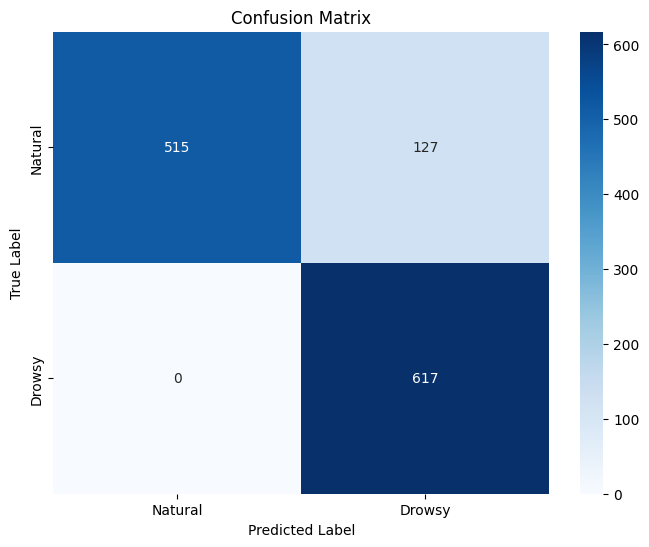

In [ ]:
# Confusion matrix

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Natural', 'Drowsy'], yticklabels=['Natural', 'Drowsy'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

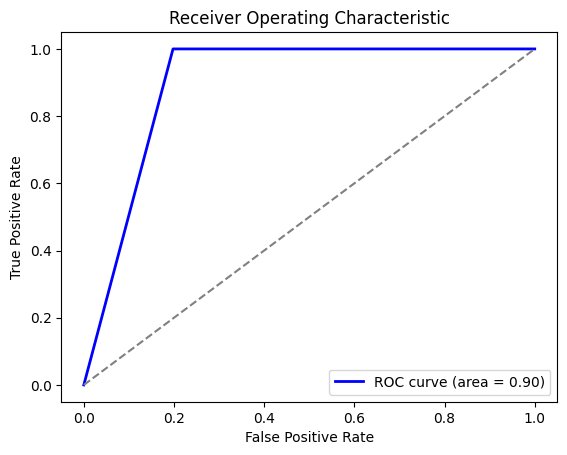

In [ ]:
fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/DrowsyDrivingDetection.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/DrowsyDrivingDetection.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 503195 bytes to /content/drive/MyDrive/Colab Notebooks/DrowsyDrivingDetection.html
